In [1]:
import numpy as np

Ngen=10000


Er = 10
Enr = Er*np.ones((Ngen,100))
V=4
eps=3.3

import resfuncRead as rfr

#read the files
ptres = rfr.getRFunc('data/jardin_ptres.txt')
qres = rfr.getRFunc('data/jardin_qsummaxres.txt')

#make the resolution functions
fpt = rfr.makeRFunc(ptres[1]['sqrt'])
fq = rfr.makeRFunc(qres[1]['lin'],True)
fptv = np.vectorize(fpt)
fqv = np.vectorize(fq)

#do the NRs
#create a yield model
import lindhard as lind

#lindhard
lpar = lind.getLindhardPars('Ge',True) #use the "calculated" value of k
ylind = lind.getLindhard(lpar)
ylindv = np.vectorize(ylind) #careful, this expects inputs in eV

Ptnr = Enr + (V/eps)*ylindv(Enr*1000.0)*Enr
print(fptv(Ptnr[0,0]))
Ptnr = Ptnr + np.random.normal(0.0,fptv(Ptnr))
Qnr = ylindv(Enr*1000.0)*Enr
print(fqv(Qnr[0,0]))
Qnr = Qnr + np.random.normal(0.0,fqv(Qnr))

Ernr = Ptnr - (V/eps)*Qnr
#Ernr = Enr
Ynr = Qnr/Ernr

#***********change over to Y******************
amean=ylind(Er*1000)
sigx = 0.05
amax = 0.1
Y = ylind(Er*1000)
print(fptv((1+(V/eps)*Y)*Er))
print(fqv(Y*Er))
#siga_both = (1/Er)*np.sqrt((1+(V/eps)*Y)**2*fqv(Y*Er)**2 + (1+(V/eps))**2*Y**2*fptv((1+(V/eps)*Y)*Er)**2)
siga_both = (1/Er)*np.sqrt((1+(V/eps)*Y)**2*fqv(Y*Er)**2 + Y**2*fptv((1+(V/eps)*Y)*Er)**2)
#print((1/Er)*np.sqrt((1+(V/eps)*Y)**2*fqv(Y*Er)**2))
#print((1/Er)*np.sqrt(Y**2*fptv((1+(V/eps)*Y)*Er)**2))
siga_q = (1/Er)*np.sqrt(fqv(Y*Er)**2)
siga = siga_both
print(siga_both)
print(siga_q)
print(siga)
A = Ynr + np.random.normal(0,sigx,np.shape(Ynr))
#***********use A*****************************
#amean=0
#sigx = 10.1
#amax = 30
#siga = 5
#A = np.random.normal(0,np.sqrt(siga**2),(Ngen,100))
#A = A + np.random.normal(0,np.sqrt(sigx**2),(Ngen,100))
#************do it the other way***************************
#amean=0
#sigx = 10.1
#amax = 30
#siga = 5
#A = np.random.normal(0,np.sqrt(siga**2_sigx**2),(Ngen,100))
#*********************************************************


print(np.shape(A))
print(np.shape(Ynr))
print(Ynr[0:5,0])
print(A[0:5,0])


0.4886859689827363
0.4272996669934894
0.4886859689827363
0.4272996669934894
0.056028679724864076
0.04272996669934895
0.056028679724864076
(10000, 100)
(10000, 100)
[0.25342103 0.33834525 0.27894369 0.25434905 0.14205036]
[0.28123269 0.35732619 0.27548788 0.32561993 0.18435198]


In [2]:
#define a Gaussian 
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [3]:
#do a fit
from scipy.optimize import curve_fit


val = []
val_stat = []
err = []
for i in np.arange(0,np.shape(A)[1]):
    v = A[:,i]
    nv,nvx = np.histogram(v,100,range=(amean-amax-sigx-0.2,amean+amax+sigx+0.2))
    xvc = (nvx[:-1] + nvx[1:]) / 2
    pars,parerr = curve_fit(gaus,xvc,nv,p0=[1000, amean, (amax/3)])
    val_stat.append(np.sqrt(np.std(v)**2-siga**2))
    val.append(np.sqrt(pars[2]**2-siga**2))
    err.append(np.sqrt(pars[2]**2/(pars[2]**2-siga**2)*parerr[2,2]))
    #err.append(np.sqrt(parerr[2,2]))
    
n,nx = np.histogram(A[:,0],100,range=(amean-amax-sigx-0.2,amean+amax+sigx+0.2))

xc = (nx[:-1] + nx[1:]) / 2

print(np.shape(n))
print(np.shape(xc))
print(amean)
print(amax)

(100,)
(100,)
0.23399324858399997
0.1


In [4]:


popt,pcov = curve_fit(gaus,xc,n,p0=[1000, amean, (amax/3)])

print(popt)
print(pcov)

[3.68500665e+02 2.33955653e-01 7.57982334e-02]
[[ 1.16742495e+01  7.41764631e-11 -1.60088050e-03]
 [ 7.41764631e-11  6.58582337e-07 -1.54133912e-14]
 [-1.60088050e-03 -1.54133912e-14  6.58582373e-07]]


In [5]:
#set up a plot 
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerLine2D
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')

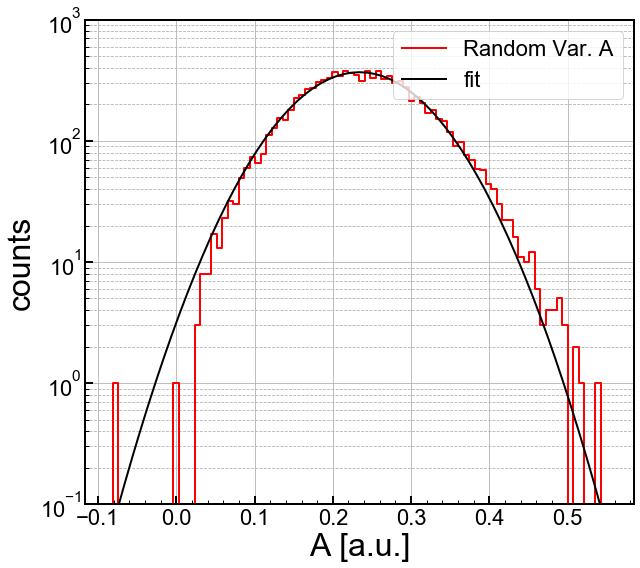

In [6]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

X = np.arange(amean-amax-sigx-0.2,amean+amax+sigx+0.2,0.01)

step, = ax1.step(xc,n, where='mid',color='r', linestyle='-', label='Random Var. A', linewidth=2)
ax1.plot(X,gaus(X,*popt),'k-',label='fit')


ymin=0.1
ymax=1000


ax1.set_yscale('log')
ax1.set_xlim(amean-amax-sigx-0.2, amean+amax+sigx+0.2)
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel('A [a.u.]',**axis_font)
ax1.set_ylabel('counts',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figures')
plt.show()

In [7]:
sig_extract = np.sqrt(popt[2]**2-siga**2)

err_extract = np.sqrt(1/(4*(sig_extract**2-siga**2))*pcov[2,2])

print('{0:3.2f} +/- {1:3.2f}'.format(sig_extract,err_extract))

0.05 +/- nan


/home/phys/villaa/python/anaconda3/envs/py365/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


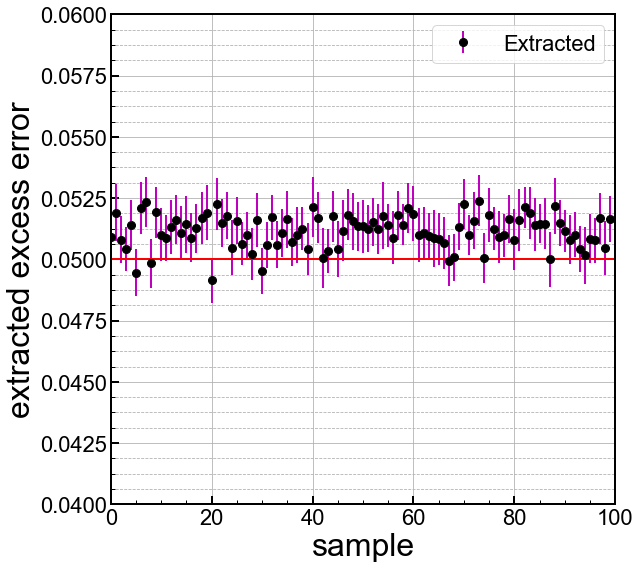

In [8]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

val_stat = np.asarray(val_stat)
val = np.asarray(val)
err = np.asarray(err)
xerr=np.zeros(np.shape(err))

ax1.errorbar(np.arange(0,np.shape(val_stat)[0]),val_stat,yerr=[err,err], marker='o', markersize=8, \
             ecolor='m',color='k', linestyle='none', label='Extracted', linewidth=2)


ax1.axhline(sigx,linestyle='-',color='r')

ymin=sigx-0.1*amax
ymax=sigx+0.1*amax


ax1.set_yscale('linear')
ax1.set_xlim(0, np.shape(val)[0]) #in pairs
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel('sample',**axis_font)
ax1.set_ylabel('extracted excess error',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figures')
plt.show()

In [9]:
print('{0:3.3f} +/- {1:3.3f}'.format(np.mean(val),(1/np.float(np.shape(err)[0]))*np.sqrt(np.sum(err**2))))

0.050 +/- 0.000


0.0006731528120798789


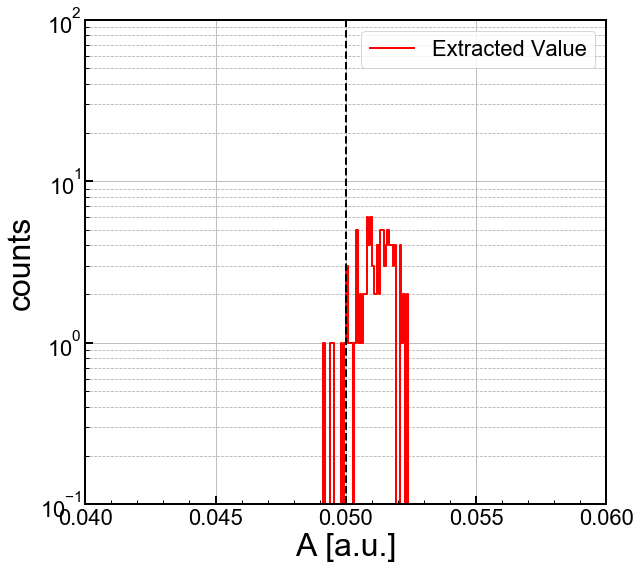

In [10]:
xmin=sigx-0.1*amax
xmax=sigx+0.1*amax

print(np.std(val_stat))

n_res,n_resx = np.histogram(val_stat,300,range=(xmin,xmax))


xresc = (n_resx[:-1] + n_resx[1:]) / 2

#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

X = np.arange(sigx-amax,sigx+amax,0.01)

step, = ax1.step(xresc,n_res, where='mid',color='r', linestyle='-', label='Extracted Value', linewidth=2)
ax1.axvline(sigx,linestyle='--',color='k')


ymin=0.1
ymax=100


ax1.set_yscale('log')
ax1.set_xlim(xmin, xmax) #in pairs
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel('A [a.u.]',**axis_font)
ax1.set_ylabel('counts',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figures')
plt.show()